# №6. Цикл обучения моделей

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

In [2]:
# plt.style.use('dark_background')

## 0. Общая логика цикла обучения модели

```python
# 1_initialization
model = MyModel()                          # Инициализация архитектуры модели
optimizer = torch.optim.Adam()            # Создание оптимизатора
criterion = nn.CrossEntropyLoss()         # Определение функции потерь

# 2_training_loop
for epoch in range(num_epochs):           # Цикл по эпохам
    model.train()                         # Переключение в режим обучения
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()             # ОБЯЗАТЕЛЬНО: обнуление градиентов
        output = model(data)              # Прямой проход (forward pass)
        loss = criterion(output, target)  # Расчет функции потерь
        loss.backward()                   # Обратный проход (backward pass)
        optimizer.step()                  # Шаг оптимизации (обновление весов)
        train_loss += loss.item()         # Накопление лосса для статистики
        predictions = output.argmax(dim=1) # Получение предсказаний
    train_accuracy = calculate_accuracy() # Расчет метрик обучения

# 3_validation_loop (inside training_loop)
    model.eval()                              # Переключение в режим оценки
    val_loss = 0.0
    with torch.no_grad():                     # ОТКЛЮЧЕНИЕ вычислительного графа
        for data, target in val_loader:
            output = model(data)              # Только прямой проход
            loss = criterion(output, target)  # Расчет потерь на валидации
            val_loss += loss.item()           # Накопление лосса валидации
            predictions = output.argmax(dim=1) # Предсказания для метрик
    val_accuracy = calculate_accuracy()       # Расчет точности на валидации
    val_losses.append(val_loss / len(val_loader)) # Сохранение метрик

# 4_metrics_logging
    print(f'Epoch {epoch+1}/{num_epochs}')    # Вывод прогресса
    print(f'Train Loss: {train_loss/len(train_loader):.4f}')
    print(f'Val Loss: {val_loss/len(val_loader):.4f}')
    print(f'Val Accuracy: {val_accuracy:.4f}')
    train_losses.append(train_loss)           # Сохранение для графиков
    val_accuracies.append(val_accuracy)       # История метрик

# 5_checkpoint_saving
if val_accuracy > best_accuracy:          # Условное сохранение
    best_accuracy = val_accuracy
    torch.save(model.state_dict(), 'best_model.pth') # Сохранение весов
    print('Модель сохранена!')

# 6_visualization
plt.plot(train_losses, label='Train Loss') # График обучения
plt.plot(val_losses, label='Val Loss')     # График валидации
plt.legend()
plt.show()
```

## 1. MNIST

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 1.1 Создание **Dataset**

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, path:str, transform=None):
        self.path = path
        self.transform = transform
        
        self.len_dataset = 0
        self.data_list = []
        
        os_walk = os.walk(self.path)
        path, dir_list, files = next(os_walk)
        self.classes = dir_list
        self.classes_to_index = {cls:i for i, cls in enumerate(sorted(self.classes))}
        
        for path, dir_list, files in os_walk:
            
            class_name = path.split(os.sep)[-1]
            
            for file in files:
                file_path = os.path.join(path, file)
                self.data_list.append((file_path, self.classes_to_index[class_name]))
            self.len_dataset += len(files)
            
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index:int):
        file_path, class_index = self.data_list[index]
        image = np.array(Image.open(file_path))
        if self.transform is not None:
            image = self.transform(image)
        return image, class_index

In [5]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

In [18]:
MNIST_FOLDER = os.path.join('data', 'MNIST', 'generated')
train_data = MNISTDataset(os.path.join(MNIST_FOLDER, 'train'), transform=transform)
test_data = MNISTDataset(os.path.join(MNIST_FOLDER, 'test'), transform=transform)
len(train_data), len(test_data)

(60000, 10000)

In [19]:
train_data, val_data = random_split(train_data, [0.7, 0.3])
len(train_data), len(val_data)

(42000, 18000)

In [22]:
BATCH_SIZE = 64
train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)
len(train_loader), len(val_loader), len(test_loader)

(657, 282, 157)

In [23]:
class myModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        hidden_size = 128
        self.layer_1 = nn.Linear(input, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, output)
        self.act_func = nn.ReLU()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act_func(x)
        out = self.layer_2(x)
        return out

In [38]:
model = myModel(784, 10).to(device)
model

myModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=10, bias=True)
  (act_func): ReLU()
)

In [39]:
x = torch.rand([16, 784], dtype=torch.float32).to(device)
out = model(x)
out.shape

torch.Size([16, 10])

*Формула категориальной кросс-энтропии:*
$$ L = -\frac{1}{n}\sum_{i=1}^{n}\sum_{c=1}^{C}y_{i,c}\log(\hat{y}_{i,c}) $$

In [40]:
loss_model = nn.CrossEntropyLoss() # Категориальная кросс-энтропия
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_model, opt

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [41]:
y_pred = torch.tensor([0.5, 0.25, 0.25])
y_true = torch.tensor([1. , 0.  , 0.  ])
loss_model(y_pred, y_true).item()

0.9390698671340942

In [ ]:
EPOCHS = 2
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# Цикл обучения
for epoch in range(EPOCHS):
    
    # Обучение модели
    model.train()
    running_train_loss = []
    true_answer = 0
    train_loop = tqdm(train_loader, leave=False)
    
    for x, targets in train_loop:
        # Обработка данных
        
        # (batch_size, 1, 28, 28) --> (batch_size, 784)
        x = x.reshape(-1, 784).to(device)
        
        # (batch_size, int) --> (butch_size, 10, dtype=torch.float32)
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)
        
        # Прямой проход и расчет ошибки модели
        pred = model(x)
        loss = loss_model(pred, targets)
        
        # Обратный проход
        opt.zero_grad() # обнуляем предыдущие градиенты
        loss.backward() # вычисялем новые градиенты
        opt.step()      # применяем шаг оптимизации
        
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        desc = f"Epoch [{epoch+1}/{EPOCHS}], {mean_train_loss=:.4f}"
        train_loop.set_description(desc)
        
    # Расчет значения точности после эпохи обучения
    running_train_acc = true_answer / len(train_data)
    
    # Сохранение значений функции потерь и точности
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Валидация модели
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # Обработка данных
        
            # (batch_size, 1, 28, 28) --> (batch_size, 784)
            x = x.reshape(-1, 784).to(device)
            
            # (batch_size, int) --> (butch_size, 10, dtype=torch.float32)
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            # Прямой проход и расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)
    
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
    
    # Расчет точности    
    running_val_acc = true_answer / len(val_data)
    
    # Сохранение значений функции потерь и точности
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    
    info = "Epoch [{}/{}], train_loss={:.4f}, train_acc={:.4f}, val_loss={:.4f}" \
    .format(epoch+1, EPOCHS, mean_train_loss, running_train_acc, mean_val_loss)
    
    print(info)

Epoch [1//2], train_loss=0.4312, train_acc=0.8746, val_loss=0.2984


Epoch [2//2], train_loss=0.2388, train_acc=0.9311, val_loss=0.2079


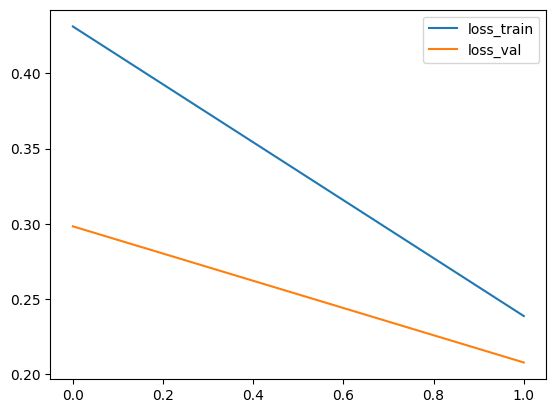

In [46]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

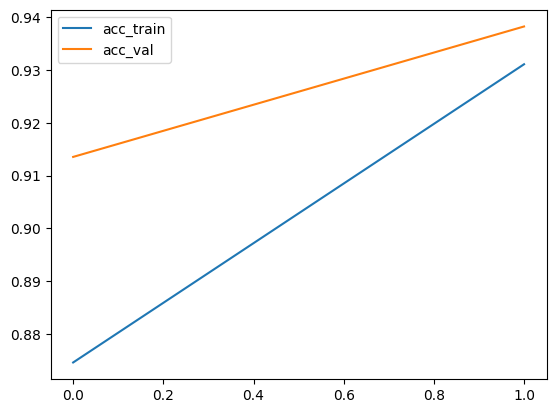

In [47]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

## 2. Сгенерированные изображения (регрессия)

In [ ]:
class GenImagesDataset(Dataset):
    def __init__(self, path:str, transform=None):
        self.path = path
        self.transform = transform
        
        self.list_file_names = os.listdir(self.path)
        if 'coords.json' in self.list_file_names:
            self.list_file_names.remove('coords.json')
            
        self.len_dataset = len(self.list_file_names)
        
        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.coords = json.load(f)
        
    def __len__(self):
        return self.len_dataset
    
    def __getitem__(self, index:int):
        file_name = self.list_file_names[index]
        path_img = os.path.join(self.path, file_name)
        
        img = Image.open(path_img)
        coords = np.array(self.coords[file_name], dtype=np.float32)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, coords

In [35]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5,), std=(0.5,))
])

In [62]:
GEN_IMAGES_FOLDER = os.path.join('data', 'GEN_IMAGES')
dataset = GenImagesDataset(path=GEN_IMAGES_FOLDER, transform=transform)
len(dataset)

100000

array([24., 33.], dtype=float32)

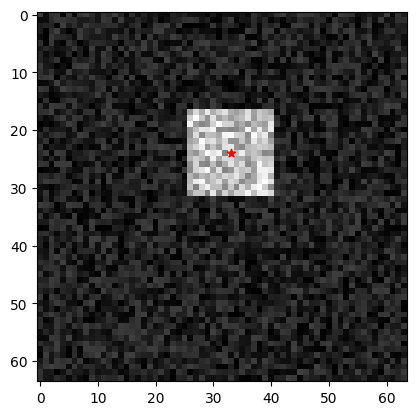

In [63]:
idx = 52
img, coords = dataset[idx]
plt.imshow(img.numpy()[0], cmap='gray')
plt.scatter(coords[1], coords[0], color='r', marker='*')
coords

In [64]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])
len(train_set), len(val_set), len(test_set)

(70000, 10000, 20000)

In [65]:
BATCH_SIZE=32
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False)

In [72]:
class myRegModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        hidden_size = 64
        self.layer_1 = nn.Linear(input, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, output)
        self.act_func = nn.ReLU()
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act_func(x)
        out = self.layer_2(x)
        return out

In [73]:
reg_model = myRegModel(64*64, 2)
reg_model

myRegModel(
  (layer_1): Linear(in_features=4096, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=2, bias=True)
  (act_func): ReLU()
)

In [74]:
x = torch.rand([3, 64*64], dtype=torch.float32).to(device)
out = reg_model(x)
out.shape, out

(torch.Size([3, 2]),
 tensor([[ 0.0063, -0.0527],
         [-0.2416, -0.2619],
         [-0.0775, -0.2196]], grad_fn=<AddmmBackward0>))

In [75]:
loss_reg_model = nn.MSELoss()
reg_opt = torch.optim.Adam(reg_model.parameters(), lr=0.001)

In [76]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

In [77]:
EPOCHS = 2

# Цикл обучения
for epoch in range(EPOCHS):
    
    # Обучение модели
    reg_model.train()
    running_train_loss = []
    true_answer = 0
    train_loop = tqdm(train_loader, leave=False)
    
    for x, targets in train_loop:
        # Обработка данных
        
        # (batch_size, 1, 64, 64) --> (batch_size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        
        targets = targets.to(device)
        
        # Прямой проход и расчет ошибки модели
        pred = reg_model(x)
        loss = loss_reg_model(pred, targets)
        
        # Обратный проход
        reg_opt.zero_grad() # обнуляем предыдущие градиенты
        loss.backward() # вычисялем новые градиенты
        reg_opt.step()      # применяем шаг оптимизации
        
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
        
        desc = f"Epoch [{epoch+1}/{EPOCHS}], {mean_train_loss=:.4f}"
        train_loop.set_description(desc)
        
    # Расчет значения точности после эпохи обучения
    running_train_acc = true_answer / len(train_set)
    
    # Сохранение значений функции потерь и точности
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Валидация модели
    reg_model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # Обработка данных
        
            # (batch_size, 1, 64, 64) --> (batch_size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            
            targets = targets.to(device)
            
            # Прямой проход и расчет ошибки модели
            pred = reg_model(x)
            loss = loss_reg_model(pred, targets)
    
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
    
    # Расчет точности    
    running_val_acc = true_answer / len(val_set)
    
    # Сохранение значений функции потерь и точности
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    
    info = "Epoch [{}/{}], train_loss={:.4f}, train_acc={:.4f}, val_loss={:.4f}" \
    .format(epoch+1, EPOCHS, mean_train_loss, running_train_acc, mean_val_loss)
    
    print(info)

Epoch [1/2], train_loss=4.3747, train_acc=0.6601, val_loss=0.0669


Epoch [2/2], train_loss=0.0818, train_acc=0.8462, val_loss=0.0580


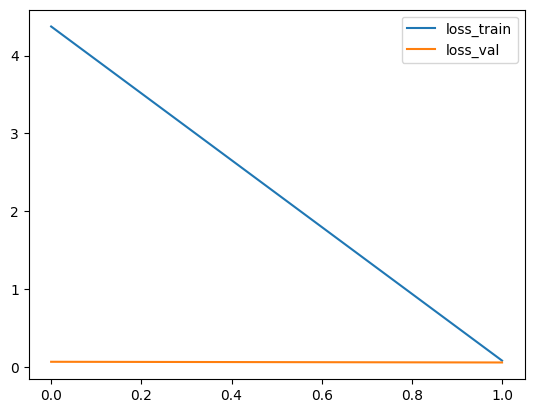

In [87]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

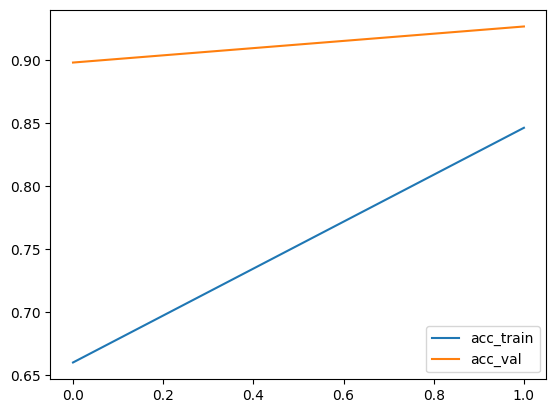

In [88]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()

(array([34., 37.], dtype=float32),
 tensor([[33.8986, 36.9578]], grad_fn=<AddmmBackward0>))

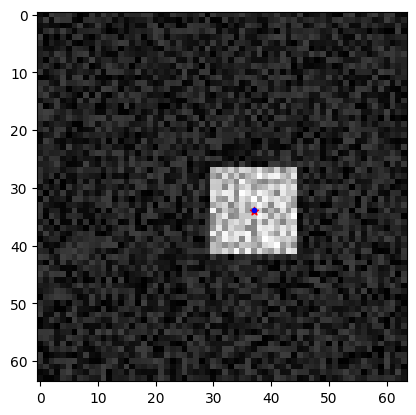

In [80]:
idx = 100
img, coords = dataset[idx]
ans_coords = reg_model(img.reshape(-1, 64*64).to(device))
plt.imshow(img.numpy()[0], cmap='gray')
plt.scatter(coords[1], coords[0], color='r', marker='*')
plt.scatter(ans_coords[0,1].item(), ans_coords[0,0].item(), color='b', marker='.')
coords, ans_coords

In [ ]:
# Выгружаем словарь с информацией о состоянии модели
torch.save(reg_model.state_dict(), "models/reg_model_state_dict_10092025_1118.pt")

In [ ]:
# Загрузка словаря состояния модели и создание новой модели
# по загруженному словарю состояния
param_model = torch.load("models/reg_model_state_dict_10092025_1118.pt")
loaded_reg_model = myRegModel(64*64, 2).to(device)
loaded_reg_model.load_state_dict(param_model)
loaded_reg_model

myRegModel(
  (layer_1): Linear(in_features=4096, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=2, bias=True)
  (act_func): ReLU()
)

(array([21., 28.], dtype=float32),
 tensor([[20.8698, 28.0701]], grad_fn=<AddmmBackward0>))

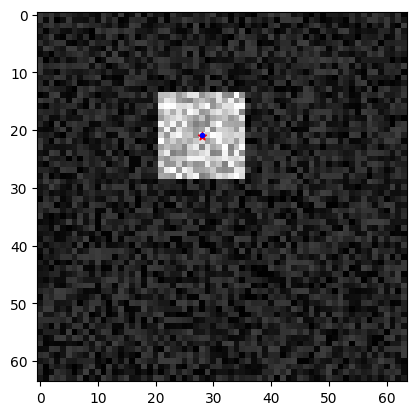

In [ ]:
# Тестируем загруженную модель
idx = 10101
img, coords = dataset[idx]
ans_coords = loaded_reg_model(img.reshape(-1, 64*64).to(device))
plt.imshow(img.numpy()[0], cmap='gray')
plt.scatter(coords[1], coords[0], color='r', marker='*')
plt.scatter(ans_coords[0,1].item(), ans_coords[0,0].item(), color='b', marker='.')
coords, ans_coords